# R laboratory exercises 07
### Laboratory session: May 12, 2021
### Exercises due on: May 30, 2021

#### Samuele Piccinelli, 2027650
#### samuele.piccinelli@studenti.unipd.it

In [1]:
# import libraries and useful dependencies
library(ggplot2)
library(latex2exp)
library(data.table)
# suppress warnings of masked objects
suppressMessages(library(bayestestR))
suppressMessages(library(reshape2))
# plot settings
options(repr.plot.width=10, repr.plot.height=5)
theme_set(theme_bw() + theme(text=element_text(family='Times New Roman', size=12), legend.text=element_text(size=12)))

***
Some useful function for the following analysis are first defined. Mean, median and variance are calculated numerically given:
- a grid of points on the $x$-axis `x`;
- the corresponding values of the distribution function `d`;
- the distance between two consecutive values `delta`.

When possible the functions `map_estimate` and `describe_posterior` of the _R_ package `bayestestR` are used to calculate the most probable value and the estimates for mean, variance and the $95\%$ confidence interval on the posterior distribution respectively.

In [2]:
get.mean <- function(x, d, delta){
    return(sum(x*d*delta))
}

get.median <- function(x, d, delta){
    integral <- cumsum(d)*delta
    last.index <- length(which(integral<=0.5))
    return(x[last.index])
}

get.variance <- function(x, d, delta){
    mean <- get.mean(x, d, delta)
    return(sum((mu-mean)**2*delta*d))
}

# find MPV
get.max = function(x, d){
    return(x[which(d>=max(d))[1]])
}

#### Exercise 1
A  well established and diffused method for detecting a disease in blood fails to detect the presence of disease in $15\%$ of the patients that actually have the disease. A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of $n = 75$ patients known to have the disease is screened using the new method.

1. What is the probability distribution of $y$, the number of times the new method fails to detect the disease?
2. On the $n = 75$ patients sample, the new method fails to detect the disease in $y = 6$ cases. What is the frequentist estimator of the failure probability of the new method?
3. Setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value $0.15$ and standard deviation $0.14$. Plot the posterior distribution for $y$, and mark on the plot the mean value and variance.
4. Perform a test of hypothesis assuming that if the probability of failing to the detect the disease in ill patients is greater or equal than $15\%$, the new test is no better that the traditional method. Test the sample at a $5\%$ level of significance in the Bayesian way.
5. Perform the same hypothesis test in the classical frequentist way.

***
The probability distribution of $y$ is a binomial distribution with $n$ being the number of samples and $y$ the number of cases in which the new method fails to detect the disease.

For the bayesian computation, the likelihood is given by a Binomial distribution with $n=75$ and $y=6$.<br>
Given mean $\mu$ and variance $\sigma^2$, the parameters $\alpha$ and $\beta$ of the Beta distribution are given by

$$\alpha = \left(\frac{1-\mu}{\sigma^2}-\frac{1}{\mu}\right)\mu^2$$

$$\beta = \alpha\left(\frac{1}{\mu}-1\right)$$

In [3]:
p.H0 <- .15; alpha <- 0.05
n <- 75; y <- 6

In [4]:
f.e <- y/n
cat('Frequentist estimator for y:', round(f.e,4))

Frequentist estimator for y: 0.08

In [5]:
n.sample <- 2000; delta.p <- 1/n.sample
p <- seq(from=1/(2*n.sample), by=1/n.sample, length.out=n.sample)

mu <- .15; sig <- .14
alpha <- ((1 - mu)/sig**2 - 1/mu)*mu**2
beta <- alpha*(1/mu - 1)

prior <- dbeta(p,alpha,beta)
likelihood <- dbinom(x=y, size=n, prob=p)
posterior <- dbeta(x=p, alpha+y, beta+n-y)
posterior.n <- posterior/(delta.p*sum(posterior))

In [6]:
b.computation <- melt(data.table(p, 'Prior'=prior, 'Likelihood'=likelihood, 'Posterior'=posterior.n), id='p')

post.test <- distribution_beta(1000, alpha+y, beta+n-y)
mpv.b <- map_estimate(post.test)
estimates.b <- describe_posterior(post.test, centrality='mean', dispersion=TRUE, ci_method='eti', test=NULL)

mean.value <- estimates.b[1,2]
sigma <- estimates.b[1,3]
var.low    <- mean.value - sigma
var.high   <- mean.value + sigma

threshold <- data.frame(x = c(mean.value, var.low, var.high, estimates.b[1,5], estimates.b[1,6]),
                        Estimates = c('Mean', 'µ±σ', 'µ±σ', 'p2.5% / p97.5%', 'p2.5% / p97.5%'))

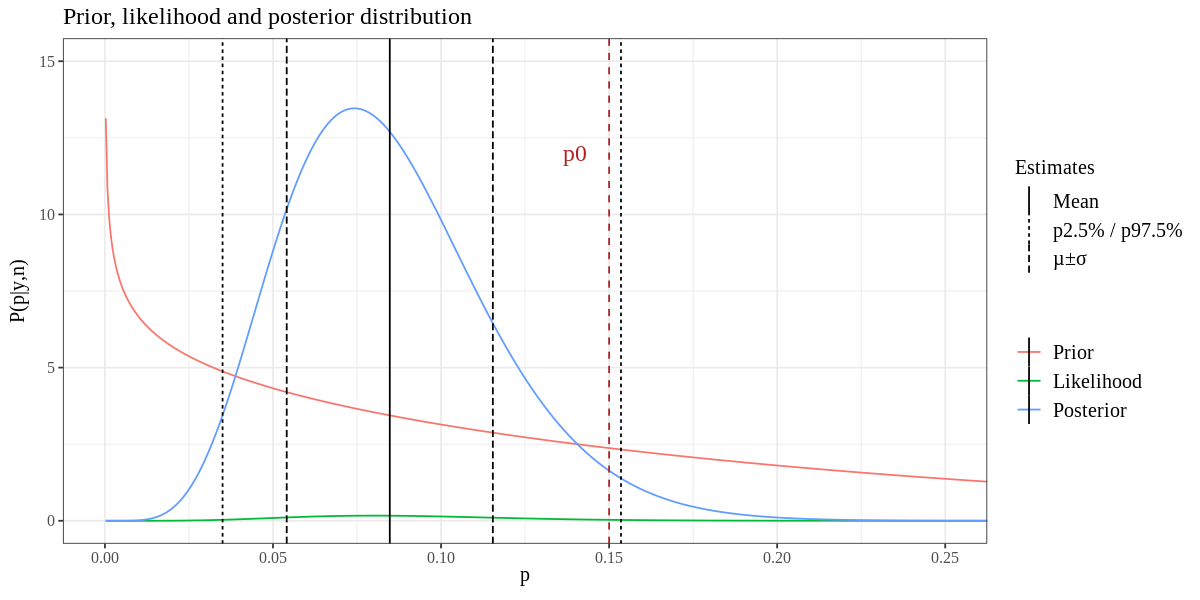

In [7]:
ggplot(b.computation, aes(p, value, col=variable)) + geom_line(size=.5) + coord_cartesian(xlim=c(0,.25), ylim=c(0,15)) +
geom_vline(aes(xintercept = x, linetype = Estimates), show.legend = TRUE, data = threshold) +
geom_vline(xintercept = p.H0, linetype='dashed', col = 'firebrick', size=0.5) +
annotate('text', x=0.14, y=12, label='p0', col='firebrick', family='Times New Roman', size=5) +
labs(title='Prior, likelihood and posterior distribution', x=TeX('$p$'), y=TeX('$P(p | y,n)$'), col='')

In [8]:
ys <- c(0:n)
ps <- pbinom(ys, size=n, p=p.H0)

ht.f <- data.table(y=ys, p=dbinom(ys, size=n, p=p.H0))
ys.0.025 <- ys[ps<=0.025]; ys.0.975 <- ys[(1-ps)<=0.025]
ys.acc <- ys[ps>0.025 & (1-ps)>0.025]
colors <- c(rep('firebrick', length(ys.0.025)), rep('seagreen',  length(ys.acc)), rep('firebrick', length(ys.0.975)))

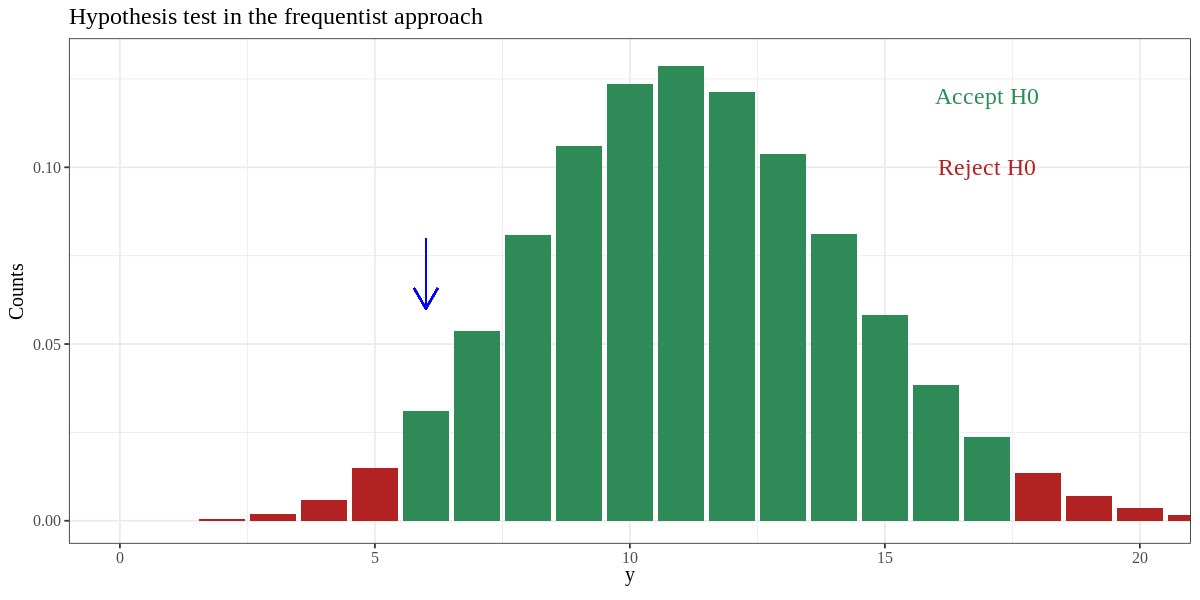

In [9]:
ggplot(ht.f[1:30], aes(x=y, y=p)) + geom_bar(stat='identity', fill=colors[1:30]) +
coord_cartesian(xlim=c(0,20), ylim=c(0,.13)) +
labs(title='Hypothesis test in the frequentist approach', x=TeX('y'), y='Counts') +
geom_segment(aes(x=6, y=.08, xend=6, yend=.06), arrow = arrow(length = unit(0.5, 'cm')), colour='blue') +
annotate('text', x=17., y=.12, label='Accept H0', col='seagreen', family='Times New Roman', size=5) +
annotate('text', x=17., y=.10, label='Reject H0', col='firebrick', family='Times New Roman', size=5)

As one can see from the plots above, in both the bayesian and frequentist approach we can not reject the null hypothesis at a $5\%$ level of significance since both $p_0 = p(H_0)$ and $y$ respectively fall in the acceptance region.

#### Exercise 2
Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different corps:

| $$y$$ death soldiers | $$0$$ | $$1$$ | $$2$$ | $$3$$ | $$4$$ | $$\geq5$$ |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| $$n_1$$ observations | 109 | 65 | 22 | 3 | 1 | 0 |
| $$n_2$$ observations | 144 | 91 | 32 | 11 | 2 | 0 |

1. Assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the $95\%$ credibility interval.
2. Assuming now a Jeffrey's prior, $g(\lambda)\propto 1/\sqrt{\lambda}$, with $\lambda> 0$, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the $95\%$ credibility interval.

In [10]:
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)

ci.95 <- 0.025

In [11]:
# - FIRST CORP

delta.mu <- 0.001; delta.t <- 50
mu <- seq(20,delta.t,delta.mu)

alpha.unif.c1 <- sum(n1)+1
alpha.jeff.c1 <- sum(n1)+1/2
lambda.c1 <- length(n1)

In [12]:
post.unif.c1 <- dgamma(mu, alpha.unif.c1, lambda.c1)
post.unif.norm.c1 <- post.unif.c1/(delta.mu*sum(post.unif.c1))

post.jeff.c1 <- dgamma(mu, alpha.jeff.c1, lambda.c1)
post.jeff.norm.c1 <- post.jeff.c1/(delta.mu*sum(post.jeff.c1))

posteriors.c1 <- melt(data.table(mu, 'Uniform'=post.unif.norm.c1, 'Jeffrey'=post.jeff.norm.c1), id='mu')

In [13]:
mean.unif.c1   <- get.mean(mu, post.unif.norm.c1, delta.mu)
var.unif.c1    <- get.variance(mu, post.unif.norm.c1, delta.mu)
median.unif.c1 <- get.median(mu, post.unif.norm.c1, delta.mu)
ci.unif.c1     <- qgamma(c(ci.95, 1-ci.95), alpha.unif.c1, lambda.c1)
Uniform        <- c(mean.unif.c1, median.unif.c1, var.unif.c1, ci.unif.c1)

mean.jeff.c1   <- get.mean(mu, post.jeff.norm.c1, delta.mu)
var.jeff.c1    <- get.variance(mu, post.jeff.norm.c1, delta.mu)
median.jeff.c1 <- get.median(mu, post.jeff.norm.c1, delta.mu)
ci.jeff.c1     <- qgamma(c(ci.95, 1-ci.95), alpha.jeff.c1, lambda.c1)
Jeffrey        <- c(mean.jeff.c1, median.jeff.c1, var.jeff.c1, ci.jeff.c1)

Estimates <- c('Mean', 'Median', 'Variance', '95%CI low', '95%CI high')
estimates.c1 <- data.frame(Estimates, Uniform, Jeffrey)
cat('Estimates for 1st Corp:')
estimates.c1

Estimates for 1st Corp:

Estimates,Uniform,Jeffrey
Mean,33.500000,33.416667
Median,33.443000,33.360000
Variance,5.583333,5.569444
95%CI low,29.028608,28.951040
95%CI high,38.286997,38.197897


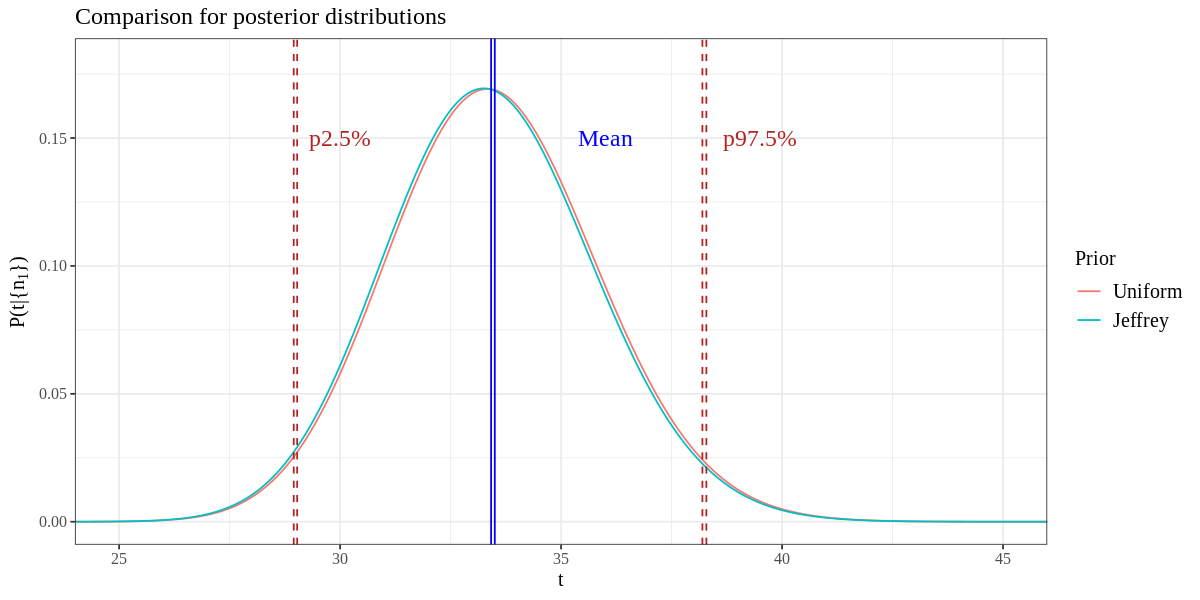

In [14]:
ggplot(posteriors.c1, aes(mu, value, col=variable)) + geom_line(size=.5) + coord_cartesian(xlim=c(25,45), ylim=c(0,.18)) +
labs(title='Comparison for posterior distributions', x='t', y=TeX('$P(t | \\{n_1\\})$'), col='Prior') +
geom_vline(xintercept = c(estimates.c1$Uniform[4], estimates.c1$Uniform[5]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept = c(estimates.c1$Jeffrey[4], estimates.c1$Jeffrey[5]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept=estimates.c1$Uniform[1], col='blue', size=0.5) +
geom_vline(xintercept=estimates.c1$Jeffrey[1], col='blue', size=0.5) +
annotate('text', x=36, y=.15, label='Mean', col='blue', family='Times New Roman', size=5) +
annotate('text', x=30, y=.15, label='p2.5%', col='firebrick', family='Times New Roman', size=5) +
annotate('text', x=39.5, y=.15, label='p97.5%', col='firebrick', family='Times New Roman', size=5)

In [15]:
# - SECOND CORP

delta.mu <- 0.001; delta.t <- 70
mu <- seq(30,delta.t,delta.mu)

alpha.unif.c2 <- sum(n2)+1
alpha.jeff.c2 <- sum(n2)+1/2
lambda.c2 <- length(n2)

In [16]:
post.unif.c2 <- dgamma(mu,alpha.unif.c2,lambda.c2)
post.unif.norm.c2 <- post.unif.c2/(delta.mu*sum(post.unif.c2))

post.jeff.c2 <- dgamma(mu,alpha.jeff.c2,lambda.c2)
post.jeff.norm.c2 <- post.jeff.c2/(delta.mu*sum(post.jeff.c2))

posteriors.c2 <- melt(data.table(mu, 'Uniform'=post.unif.norm.c2, 'Jeffrey'=post.jeff.norm.c2), id='mu')

In [17]:
mean.unif.c2   <- get.mean(mu, post.unif.norm.c2, delta.mu)
var.unif.c2    <- get.variance(mu, post.unif.norm.c2, delta.mu)
median.unif.c2 <- get.median(mu, post.unif.norm.c2, delta.mu)
ci.unif.c2     <- qgamma(c(ci.95, 1-ci.95), alpha.unif.c2, lambda.c2)
Uniform        <- c(mean.unif.c2, median.unif.c2, var.unif.c2, ci.unif.c2)

mean.jeff.c2   <- get.mean(mu, post.jeff.norm.c2, delta.mu)
var.jeff.c2    <- get.variance(mu, post.jeff.norm.c2, delta.mu)
median.jeff.c2 <- get.median(mu, post.jeff.norm.c2, delta.mu)
ci.jeff.c2     <- qgamma(c(ci.95, 1-ci.95), alpha.jeff.c2, lambda.c2)
Jeffrey        <- c(mean.jeff.c2, median.jeff.c2, var.jeff.c2, ci.jeff.c2)

Estimates <- c('Mean', 'Median', 'Variance', '95%CI low', '95%CI high')
estimates.c2 <- data.frame(Estimates, Uniform, Jeffrey)
cat('Estimates for 2nd Corp:')
estimates.c2

Estimates for 2nd Corp:

Estimates,Uniform,Jeffrey
Mean,46.833333,46.750000
Median,46.777000,46.693000
Variance,7.805556,7.791667
95%CI low,41.517030,41.438572
95%CI high,52.465274,52.377065


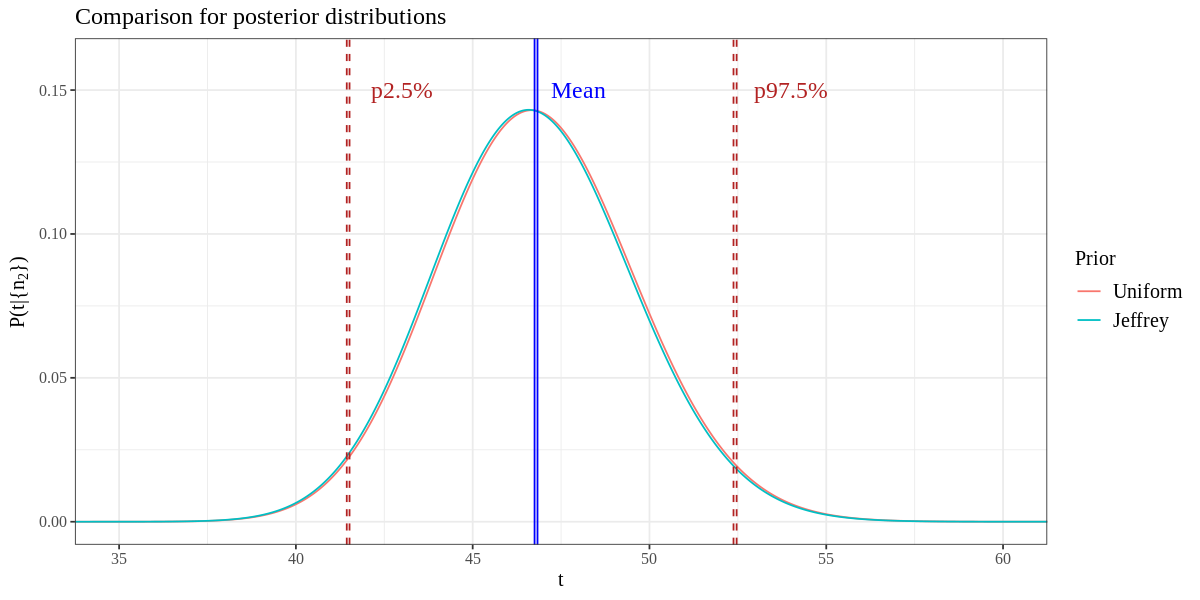

In [18]:
ggplot(posteriors.c2, aes(mu, value, col=variable)) + geom_line(size=.5) + coord_cartesian(xlim=c(35,60), ylim=c(0,.16)) +
labs(title='Comparison for posterior distributions', x='t', y=TeX('$P(t | \\{n_2\\})$'), col='Prior') +
geom_vline(xintercept = c(estimates.c2$Uniform[4], estimates.c2$Uniform[5]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept = c(estimates.c2$Jeffrey[4], estimates.c2$Jeffrey[5]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept=estimates.c2$Uniform[1], col='blue', size=0.5) +
geom_vline(xintercept=estimates.c2$Jeffrey[1], col='blue', size=0.5) +
annotate('text', x=48, y=.15, label='Mean', col='blue', family='Times New Roman', size=5) +
annotate('text', x=43, y=.15, label='p2.5%', col='firebrick', family='Times New Roman', size=5) +
annotate('text', x=54, y=.15, label='p97.5%', col='firebrick', family='Times New Roman', size=5)

For both datasets, the choice of the prior does not affect the posterior distributions which almost identically overlap; the same holds consequently for the mean and the $95\%$ confidence interval.

#### Exercise 3
A study on water quality of streams, a high level of bacter $X$ was defined as a level greater than $100$ per $100ml$ of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter $X$ level.<br>
Indicating with $p$ the probability that a sample of water taken from the stream has a high bacter $X$ level:
1. Find the frequentist estimator for $p$.
2. Using a $Beta(1, 10)$ prior for $p$, calculate the posterior distribution $P(p|y)$.
3. Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval.
4. Test the hypotesis
$$H_0: p=0.1 \text{ versus } H_1: p\neq0.1$$
at $5\%$ level of significance with both the frequentist and bayesian approach.

A new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter $X$ level.

5. Find the frequentist estimator for $p$.
6. Find a bayesian estimator for $p$, assuming both a $Beta(1, 10)$ prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.
7. Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval.
8. Test the hypotesis
$$H_0: p=0.1 \text{ versus } H_1: p\neq0.1$$
at $5\%$ level of significance with both the frequentist and bayesian approach.

In [19]:
n <- 116; y <- 11

In [20]:
f.e.1 <- y/n
cat('Frequentist estimator for p:', round(f.e.1,4))

Frequentist estimator for p: 0.0948

In [21]:
n.p <- 1000
p <- seq(0, 1, length.out=n.p)
delta.p <- (max(p)-min(p))/n.p

a <- 1; b <- 10
ap.1 <- a+y; bp.1 <- b+n-y
# equal to: dbinom(x=y, size=n, prob=p) * dbeta(p, shape1=a, shape2=b)
post.1   <- dbeta(p, shape1=ap.1, shape2=bp.1)
post.n.1 <- post.1 / (delta.p*sum(post.1))

In [22]:
post.1.test <- distribution_beta(1000, ap.1, bp.1)
b.e.1 <- ap.1/(ap.1+bp.1)
mpv.b.1 <- map_estimate(post.1.test)
estimates.b.1 <- describe_posterior(post.1.test, centrality='mean', dispersion=TRUE, ci_method='eti', test=NULL)

cat('B. estimator for p:\t', round(b.e.1,4), '\n\n')
cat('Most probable value:\t', round(mpv.b.1,4), '\n\n')
estimates.b.1

B. estimator for p:	 0.0945 

Most probable value:	 0.0885 



Parameter,Mean,SD,CI,CI_low,CI_high
Posterior,0.09446354,0.02570253,0.95,0.05046437,0.1502969


In [23]:
p.H0  <- 0.1; alpha <- 0.05

ys <- c(0:n)
ps <- pbinom(ys, size=n, p=p.H0)

ht.f.1 <- data.table(y=ys, p=dbinom(ys, size=n, p=p.H0))
ys.0.025 <- ys[ps<=0.025]; ys.0.975 <- ys[(1-ps)<=0.025]
ys.acc <- ys[ps>0.025 & (1-ps)>0.025]
colors <- c(rep('firebrick', length(ys.0.025)), rep('seagreen',  length(ys.acc)), rep('firebrick', length(ys.0.975)))

ht.b.1 <- data.table(p, 'Posterior'=post.1)

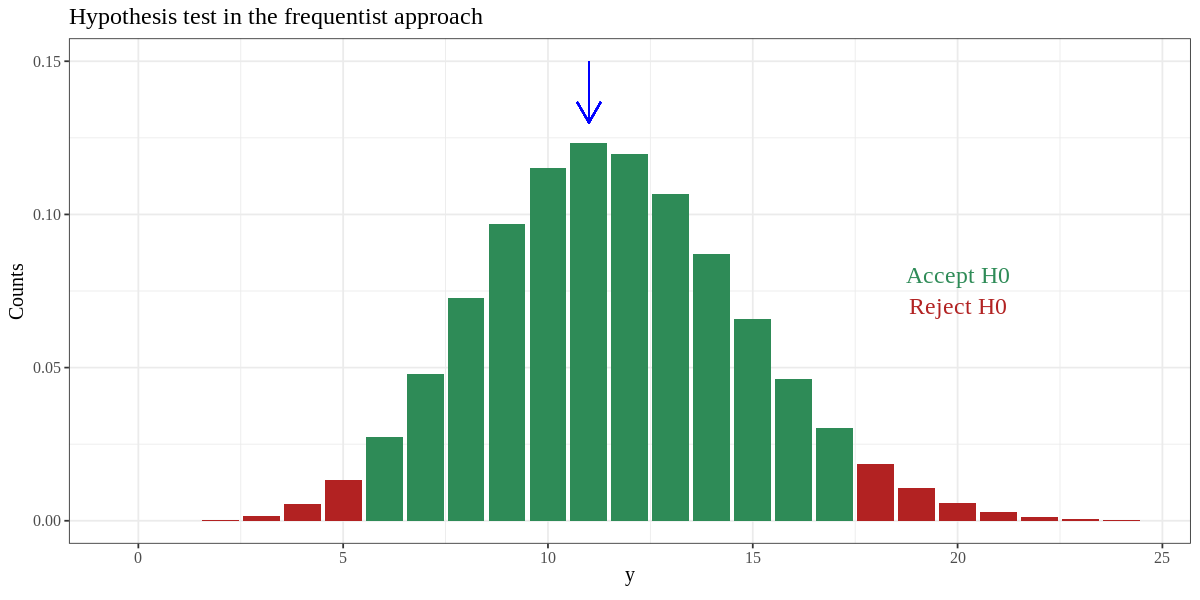

In [24]:
ggplot(ht.f.1[1:25], aes(x=y, y=p)) + geom_bar(stat='identity', fill=colors[1:25]) +
labs(title='Hypothesis test in the frequentist approach', x=TeX('y'), y='Counts') +
geom_segment(aes(x=11, y=.15, xend=11, yend=.13), arrow = arrow(length = unit(0.5, 'cm')), colour='blue') +
annotate('text', x=20., y=.08, label='Accept H0', col='seagreen', family='Times New Roman', size=5) +
annotate('text', x=20., y=.07, label='Reject H0', col='firebrick', family='Times New Roman', size=5)

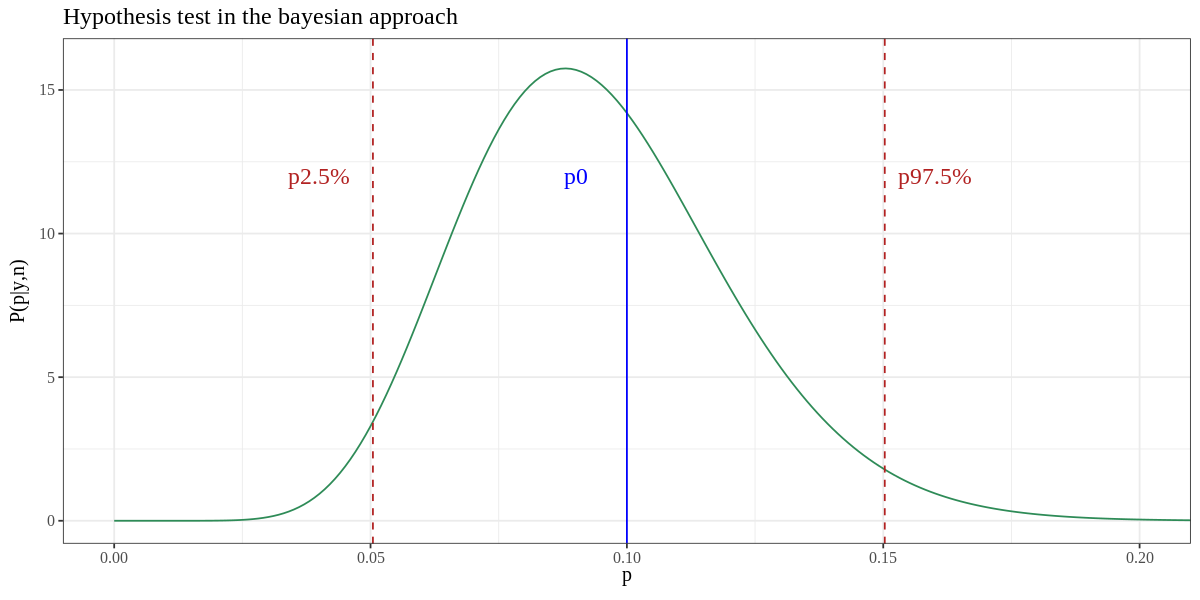

In [25]:
ggplot(ht.b.1, aes(p, post.1)) + geom_line(size=.5, col='seagreen') + coord_cartesian(xlim=c(0,.2), ylim=c(0,16)) +
geom_vline(xintercept = c(estimates.b.1[1,5],estimates.b.1[1,6]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept=p.H0, col='blue', size=0.5) +
labs(title='Hypothesis test in the bayesian approach', x=TeX('$p$'), y=TeX('$P(p | y,n)$')) +
annotate('text', x=.09, y=12, label='p0', col='blue', family='Times New Roman', size=5) +
annotate('text', x=.04, y=12, label='p2.5%', col='firebrick', family='Times New Roman', size=5) +
annotate('text', x=.16, y=12, label='p97.5%', col='firebrick', family='Times New Roman', size=5)

As one can see from the plots above, in both the bayesian and frequentist approach we can not reject the null hypothesis at a $5\%$ level of significance since both $p_0 = p(H_0)$ and $y$ respectively fall in the acceptance region.

In [26]:
n <- 165; y <- 9

In [27]:
f.e.2 <- y/n
cat('Frequentist estimator for p:', round(f.e.2,4))

Frequentist estimator for p: 0.0545

In [28]:
# Assuming a Beta(1, 10) prior
ap.2 <- a+y; bp.2 <- b+n-y

post.2   <- dbeta(p, shape1=ap.2, shape2=bp.2)
post.n.2 <- post.2 / (delta.p*sum(post.2))

post.2.test <- distribution_beta(1000, ap.2, bp.2)
b.e.2 <- ap.2/(ap.2+bp.2)
mpv.b.2 <- map_estimate(post.2.test)
estimates.b.2 <- describe_posterior(post.2.test, centrality='mean', dispersion=TRUE, ci_method='eti', test=NULL)

cat('Assuming a Beta(1, 10) prior:\n\n')
cat('B. estimator for p:\t', round(b.e.2,4), '\n\n')
cat('Most probable value:\t', round(mpv.b.2,4), '\n\n')
estimates.b.2

Assuming a Beta(1, 10) prior:

B. estimator for p:	 0.0568 

Most probable value:	 0.052 



Parameter,Mean,SD,CI,CI_low,CI_high
Posterior,0.0567987,0.01729291,0.95,0.0279141,0.09499877


In [29]:
# Assuming as prior the posterior of the older measurement
ap.3 <- ap.1+y; bp.3 <- bp.1+n-y

post.3   <- dbeta(p, shape1=ap.3, shape2=bp.3)
post.n.3 <- post.3 / (delta.p*sum(post.3))

post.3.test <- distribution_beta(1000, ap.3, bp.3)
b.e.3 <- ap.3/(ap.3+bp.3)
mpv.b.3 <- map_estimate(post.3.test)
estimates.b.3 <- describe_posterior(post.3.test, centrality='mean', dispersion=TRUE, ci_method='eti', test=NULL)

cat('Assuming as prior the posterior of the older measurement:\n\n')
cat('B. estimator for p:\t', round(b.e.3,4), '\n\n')
cat('Most probable value:\t', round(mpv.b.3,4), '\n\n')
estimates.b.3

Assuming as prior the posterior of the older measurement:

B. estimator for p:	 0.0719 

Most probable value:	 0.0691 



Parameter,Mean,SD,CI,CI_low,CI_high
Posterior,0.07190629,0.01500576,0.95,0.04540386,0.1038505


In [30]:
ys <- c(0:n)
ps <- pbinom(ys, size=n, p=p.H0)

ht.f.2 <- data.table(y=ys, p=dbinom(ys, size=n, p=p.H0))
ys.0.025 <- ys[ps<=0.025]; ys.0.975 <- ys[(1-ps)<=0.025]
ys.acc <- ys[ps>0.025 & (1-ps)>0.025]
colors <- c(rep('firebrick', length(ys.0.025)), rep('seagreen',  length(ys.acc)), rep('firebrick', length(ys.0.975)))

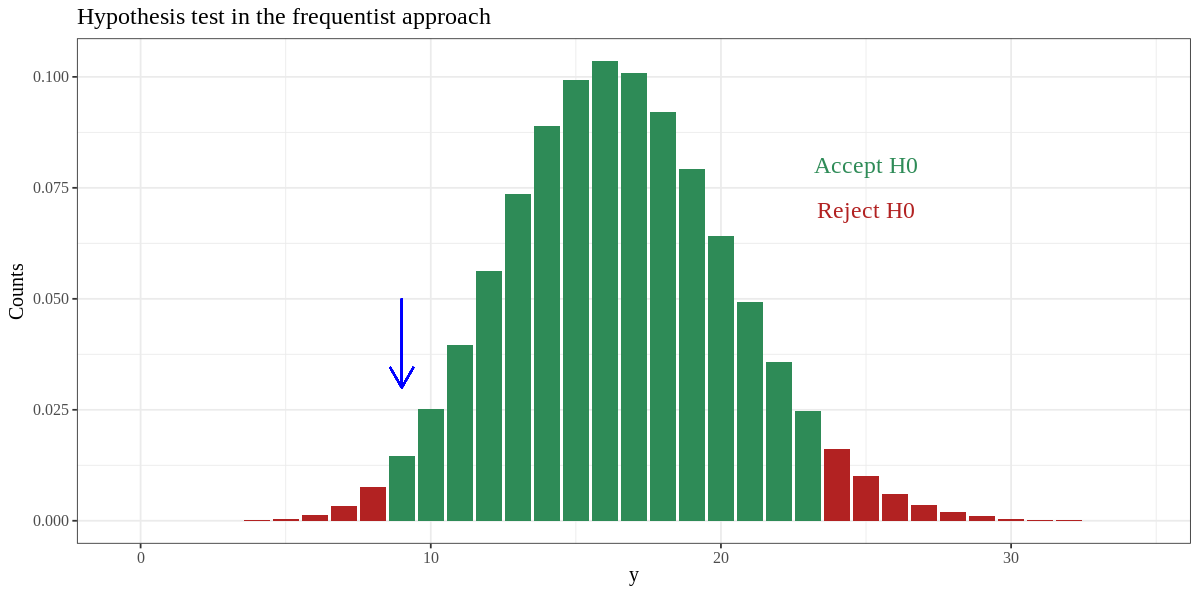

In [31]:
ggplot(ht.f.2[1:35], aes(x=y, y=p)) + geom_bar(stat='identity', fill=colors[1:35]) +
labs(title='Hypothesis test in the frequentist approach', x=TeX('y'), y='Counts') +
geom_segment(aes(x=9, y=.05, xend=9, yend=.03), arrow = arrow(length = unit(0.5, 'cm')), colour='blue') +
annotate('text', x=25., y=.08, label='Accept H0', col='seagreen', family='Times New Roman', size=5) +
annotate('text', x=25., y=.07, label='Reject H0', col='firebrick', family='Times New Roman', size=5)

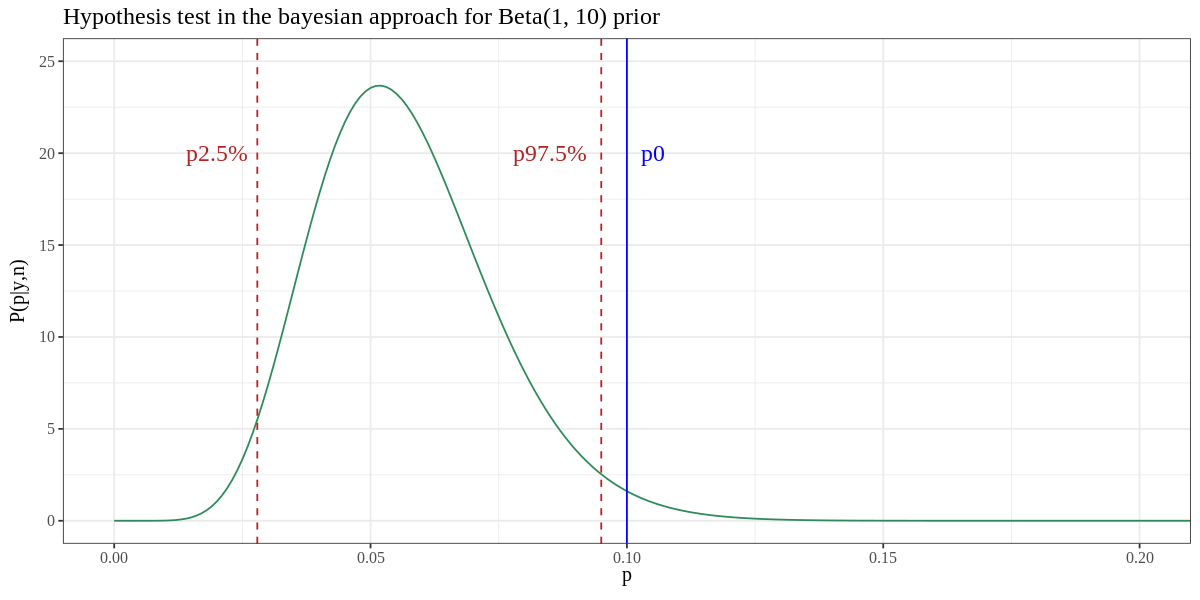

In [32]:
# Assuming a Beta(1, 10) prior
ht.b.2 <- data.table(p, 'Posterior'=post.2)

ggplot(ht.b.2, aes(p, post.2)) + geom_line(size=.5, col='seagreen') + coord_cartesian(xlim=c(0,.2), ylim=c(0,25)) +
geom_vline(xintercept = c(estimates.b.2[1,5],estimates.b.2[1,6]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept=p.H0, col='blue', size=0.5) +
labs(title='Hypothesis test in the bayesian approach for Beta(1, 10) prior', x=TeX('$p$'), y=TeX('$P(p | y,n)$')) +
annotate('text', x=.105, y=20, label='p0', col='blue', family='Times New Roman', size=5) +
annotate('text', x=.02, y=20, label='p2.5%', col='firebrick', family='Times New Roman', size=5) +
annotate('text', x=.085, y=20, label='p97.5%', col='firebrick', family='Times New Roman', size=5)

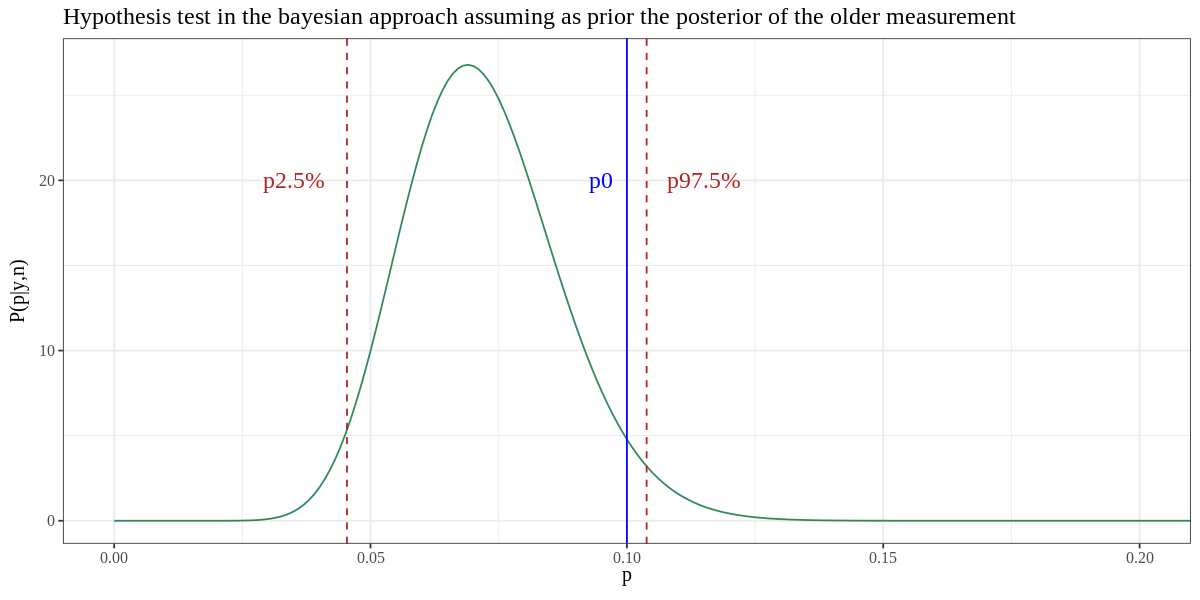

In [33]:
# Assuming as prior the posterior of the older measurement
ht.b.3 <- data.table(p, 'Posterior'=post.3)

ggplot(ht.b.3, aes(p, post.3)) + geom_line(size=.5, col='seagreen') + coord_cartesian(xlim=c(0,.2), ylim=c(0,27)) +
geom_vline(xintercept = c(estimates.b.3[1,5],estimates.b.3[1,6]), linetype='dashed', col = 'firebrick', size=0.5) +
geom_vline(xintercept=p.H0, col='blue', size=0.5) +
labs(title='Hypothesis test in the bayesian approach assuming as prior the posterior of the older measurement',
     x=TeX('$p$'), y=TeX('$P(p | y,n)$')) +
annotate('text', x=.095, y=20, label='p0', col='blue', family='Times New Roman', size=5) +
annotate('text', x=.035, y=20, label='p2.5%', col='firebrick', family='Times New Roman', size=5) +
annotate('text', x=.115, y=20, label='p97.5%', col='firebrick', family='Times New Roman', size=5)

As one can see from the plots above, for the frequentist approach we accept the null hypothesis at a $5\%$ level of significance since $y$ falls in the acceptance region.

For the bayesian approach we reject the null hypothesis at a $5\%$ level of significance for the $Beta(1,10)$ prior while we accept it when assuming as prior the posterior of the older measurement ($p_0 = p(H_0)$ falls in the rejection and acceptance region respectively).